<a href="https://colab.research.google.com/github/JackyXie888/DL-HW2/blob/main/%E6%B7%B1%E5%BA%A6%E5%AD%B8%E7%BF%92HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# 從本地端上傳已經處理好的train和val檔案
from google.colab import files
uploaded = files.upload()

Saving imagenette_160.zip to imagenette_160.zip
Saving mini_coco_det.zip to mini_coco_det.zip
Saving mini_voc_seg.zip to mini_voc_seg.zip


In [7]:
import os
import zipfile
from pathlib import Path
import shutil

def unzip_and_flatten(zip_path, dest_root="data"):
    zip_path = Path(zip_path)
    name = zip_path.stem.lower()
    out_dir = Path(dest_root) / name
    out_dir.mkdir(parents=True, exist_ok=True)

    with zipfile.ZipFile(zip_path, 'r') as zf:
        zf.extractall(out_dir)

    # 清除多餘一層的情況，如：data/imagenette_160/imagenette_160
    nested_dir = out_dir / name
    if nested_dir.exists() and nested_dir.is_dir():
        for item in nested_dir.iterdir():
            shutil.move(str(item), str(out_dir))
        shutil.rmtree(nested_dir)

    # Imagenette 特例：多一層 data/imagenette_160/train
    if (out_dir / "data" / "imagenette_160").exists():
        src = out_dir / "data" / "imagenette_160"
        for sub in ["train", "val"]:
            if (src / sub).exists():
                shutil.move(str(src / sub), str(out_dir / sub))
        shutil.rmtree(out_dir / "data")

    print(f"[INFO] 解壓完成並整理結構：{out_dir}")

# 使用範例
unzip_and_flatten("imagenette_160.zip")
unzip_and_flatten("mini_coco_det.zip")
unzip_and_flatten("mini_voc_seg.zip")


[INFO] 解壓完成並整理結構：data/imagenette_160
[INFO] 解壓完成並整理結構：data/mini_coco_det
[INFO] 解壓完成並整理結構：data/mini_voc_seg


In [18]:
pip install --upgrade torch ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

## 資料預處理

Train size: 240
Val size: 60


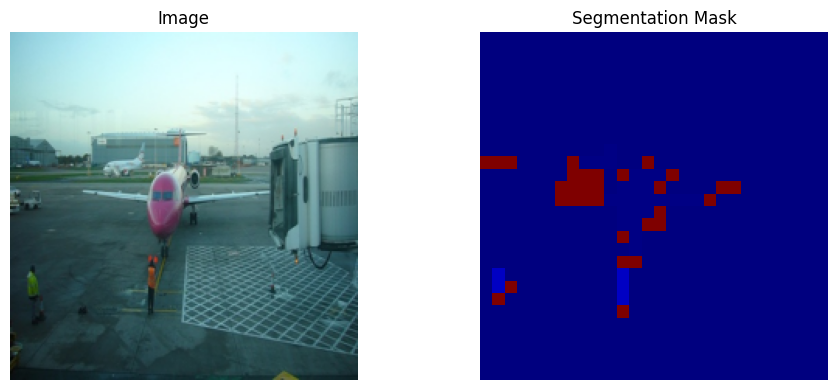

In [4]:
# 處理 voc 資料集
import os
from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as T

# === 直接定義在這份程式裡 ===
class VOCSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None, num_classes=21):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_names = sorted(os.listdir(image_dir))
        self.transform = transform
        self.mask_transform = mask_transform
        self.num_classes = num_classes

    def __getitem__(self, index):
        image_path = os.path.join(self.image_dir, self.image_names[index])
        mask_path = os.path.join(self.mask_dir, self.image_names[index].replace(".jpg", ".png"))

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask).squeeze(0).long()
            mask[mask >= self.num_classes] = 255  # 超過類別的設成 ignore_index

        return image, mask

    def __len__(self):
        return len(self.image_names)

# === transform 設定 ===
image_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

mask_transform = T.Compose([
    T.Resize((28, 28), interpolation=Image.NEAREST),
    T.PILToTensor()
])

# === 建立 dataset 實例 ===
seg_train_dataset = VOCSegmentationDataset(
    image_dir='data/mini_voc_seg/train/images',
    mask_dir='data/mini_voc_seg/train/masks',
    transform=image_transform,
    mask_transform=mask_transform,
    num_classes=21
)

seg_val_dataset = VOCSegmentationDataset(
    image_dir='data/mini_voc_seg/val/images',
    mask_dir='data/mini_voc_seg/val/masks',
    transform=image_transform,
    mask_transform=mask_transform,
    num_classes=21
)

# 检查 voc 资料
print("Train size:", len(seg_train_dataset))
print("Val size:", len(seg_val_dataset))

import matplotlib.pyplot as plt
import numpy as np

# 取一筆資料來看（例如第 0 筆）
image, mask = seg_train_dataset[0]

# 將 tensor 轉為 numpy 格式
image_np = image.permute(1, 2, 0).numpy()  # (C, H, W) → (H, W, C)
mask_np = mask.numpy()  # (H, W)

# 顯示圖像與對應 mask
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title("Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask_np, cmap="jet")
plt.title("Segmentation Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

In [7]:
# 處理 coco 資料集
import os
import json
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torch
from torchvision import transforms

class SimpleCocoDataset(Dataset):
    def __init__(self, image_dir, ann_path, transform=None):
        """
        以 JSON 方式解析 COCO annotation，完全不用 pycocotools。
        image_dir: COCO 格式 images 資料夾
        ann_path:  COCO annotation JSON 路徑 (_annotations.coco.json)
        transform: 對 PILImage 做的預處理 (例如 Resize, ToTensor, Normalize)
        """
        self.image_dir = image_dir
        self.transform = transform

        # 1. 讀入 JSON
        with open(ann_path, 'r', encoding='utf-8') as f:
            coco = json.load(f)

        # 2. 建立 image_id -> image_info 字典 (包含 file_name, width, height)
        self.imgs = { img['id']: img for img in coco['images'] }

        # 3. 建立 image_id -> list of annotations
        self.anns = {}
        for ann in coco['annotations']:
            img_id = ann['image_id']
            if img_id not in self.anns:
                self.anns[img_id] = []
            self.anns[img_id].append(ann)

        # 4. 將所有 image_id 排序，作為 dataset 的索引
        self.ids = sorted(self.imgs.keys())

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        info   = self.imgs[img_id]
        fname  = info['file_name']
        orig_w = info['width']
        orig_h = info['height']

        # 1) 讀圖
        img_path = os.path.join(self.image_dir, fname)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        # 2) 處理該 image_id 的所有 annotation
        anns = self.anns.get(img_id, [])
        boxes_list, labels_list = [], []
        for ann in anns:
            x, y, w, h = ann['bbox']  # COCO 原始：pixel 單位
            # 如果要 normalized cx,cy,w,h（YOLO 風格），做以下轉換：
            cx = (x + w / 2) / orig_w
            cy = (y + h / 2) / orig_h
            nw = w / orig_w
            nh = h / orig_h
            boxes_list.append([cx, cy, nw, nh])
            labels_list.append(ann['category_id'])

        if len(boxes_list) > 0:
            boxes  = torch.tensor(boxes_list, dtype=torch.float32)  # (N,4)
            labels = torch.tensor(labels_list, dtype=torch.int64)   # (N,)
        else:
            # 如果該圖沒有任何標註，就回傳空 Tensor
            boxes  = torch.zeros((0,4), dtype=torch.float32)
            labels = torch.zeros((0,),   dtype=torch.int64)

        target = {
            "boxes":  boxes,    # Tensor[N,4]，(cx,cy,w,h)
            "labels": labels    # Tensor[N]
        }
        return image, target

# --------------------------
# 以下示範如何使用 SimpleCocoDataset
# --------------------------

# 1) 定義 transform（將 PIL → 224×224 → Tensor）
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

# 2) 建立 train/val dataset，路徑請改成你的真實資料夾
det_train_dataset = SimpleCocoDataset(
    image_dir = "data/mini_coco_det/train",
    ann_path  = "data/mini_coco_det/train/_annotations.coco.json",
    transform = transform
)

det_val_dataset = SimpleCocoDataset(
    image_dir = "data/mini_coco_det/val",
    ann_path  = "data/mini_coco_det/val/_annotations.coco.json",
    transform = transform
)


# 3) 自訂 collate_fn，把 batch 中的多張影像和多個 target 合併
def detection_collate_fn(batch):
    """
    batch: list of tuples (image_tensor, target_dict)
    回傳:
      images: Tensor[B,3,224,224]
      targets: list of length B，每個元素是 {'boxes':Tensor[N,4], 'labels':Tensor[N]}
    """
    images, targets = zip(*batch)
    images = torch.stack(images, dim=0)
    return images, list(targets)

# 4) 建立 DataLoader
from torch.utils.data import DataLoader

train_loader = DataLoader(
    det_train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0,
    pin_memory=False,
    collate_fn=detection_collate_fn
)
val_loader = DataLoader(
    det_val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0,
    pin_memory=False,
    collate_fn=detection_collate_fn
)

# 抽查資料形態
sample_img, sample_target = det_val_dataset[0]

print("[Sample Inspection]")
print("Image shape:", sample_img.shape)  # 應為 torch.Size([3, 224, 224])
print("Boxes shape:", sample_target["boxes"].shape)  # 應為 [N, 4]，格式 (cx, cy, w, h)
print("Labels shape:", sample_target["labels"].shape)  # 應為 [N]
print("First box (normalized cx, cy, w, h):", sample_target["boxes"][0] if len(sample_target["boxes"]) > 0 else "No boxes")
print("First label:", sample_target["labels"][0] if len(sample_target["labels"]) > 0 else "No labels")

[Sample Inspection]
Image shape: torch.Size([3, 224, 224])
Boxes shape: torch.Size([1, 4])
Labels shape: torch.Size([1])
First box (normalized cx, cy, w, h): tensor([0.8819, 0.5360, 0.2358, 0.3079])
First label: tensor(49)


Dataset Mean: tensor([0.4623, 0.4563, 0.4230])
Dataset Std: tensor([0.2364, 0.2305, 0.2373])


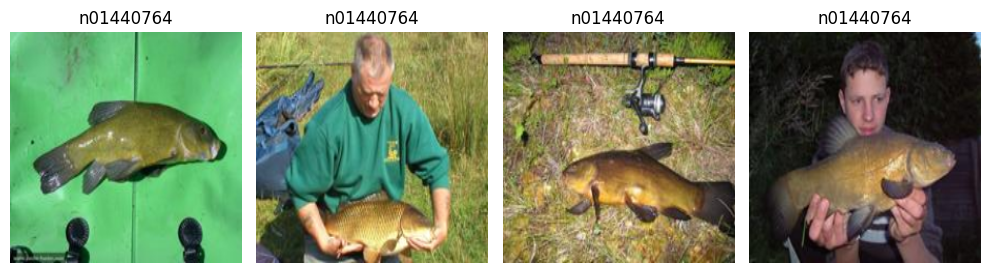

In [8]:
# 處理 160 資料
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
import torch

# 將 Windows 路徑正確處理
data_path = "data/imagenette_160/train"

# 暫時不做標準化，只做 resize + ToTensor
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 建立 ImageFolder 資料集
dataset = ImageFolder(root=data_path, transform=transform)
loader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=0)

# 初始化統計量
mean = 0.
std = 0.
nb_samples = 0

# 計算 mean / std
for data, _ in loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

# 顯示結果
print("Dataset Mean:", mean)
print("Dataset Std:", std)

mean = [0.4623, 0.4563, 0.4230]
std = [0.2364, 0.2305, 0.2373]

image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_path = "data/imagenette_160/train"
val_path   = "data/imagenette_160/val"

imagenette160_train_dataset = ImageFolder(root=train_path, transform=image_transform)
imagenette160_val_dataset   = ImageFolder(root=val_path, transform=image_transform)

def denormalize(img_tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return img_tensor * std + mean

# 抓出前 4 張驗證集圖片
plt.figure(figsize=(10, 4))
for i in range(4):
    img_tensor, label = imagenette160_val_dataset[i]  # 直接從 dataset 抓

    img_denorm = denormalize(img_tensor.clone(), mean, std)
    img_np = img_denorm.permute(1, 2, 0).numpy()  # (C, H, W) → (H, W, C)

    plt.subplot(1, 4, i + 1)
    plt.imshow(np.clip(img_np, 0, 1))
    plt.title(imagenette160_val_dataset.classes[label])
    plt.axis('off')

plt.tight_layout()
plt.show()

## model

In [12]:
import os

model_code = '''
import torch
import torch.nn as nn
from ultralytics import YOLO

import torch
import torch.nn as nn
from ultralytics import YOLO

class YOLOv8Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        # 直接載入預訓練權重（預設載到 CPU 或自動選 GPU）
        base = YOLO("yolov8n.pt")           # 取出 Ultralytics YOLO 包裝器
        layers = list(base.model.model.children())

        # 分成 stem / low / mid / high 四個階段
        self.stem = nn.Sequential(*layers[0:4])
        self.low  = nn.Sequential(*layers[4:6])
        self.mid  = nn.Sequential(*layers[6:8])
        self.high = nn.Sequential(*layers[8:10])

    def forward(self, x):
        # x: (B, 3, 224, 224)，輸入可在外層自行處理 device
        x   = self.stem(x)    # → (B,  64, 112, 112)
        low = self.low(x)     # → (B, 128,  56,  56)
        mid = self.mid(low)   # → (B, 256,  28,  28)
        high= self.high(mid)  # → (B, 256,   7,   7)
        return low, mid, high

class ConvNeck(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.neck = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )

    def forward(self, x):
        # x: (B, in_ch, 7, 7)
        return self.neck(x)   # → (B, out_ch, 7, 7)

class UnifiedHead(nn.Module):
    def __init__(self,
                 in_ch: int,
                 num_cls: int,
                 num_seg: int,
                 num_det_cls: int,
                 num_anchors: int):
        super().__init__()
        # 1. 分類 Head (Global Average Pool → Linear)
        self.cls_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),     # (B, in_ch, 1, 1)
            nn.Flatten(),                # (B, in_ch)
            nn.Linear(in_ch, num_cls)    # (B, num_cls)
        )
        # 2. 分割 Head (conv → conv → upsample)
        self.seg_head = nn.Sequential(
            nn.Conv2d(in_ch, num_seg, kernel_size=1),
            nn.Upsample(scale_factor=4, mode="bilinear", align_corners=False)
        )
        # 3. 偵測 Head (conv → conv)
        # 輸出維度：A * (4 + 1 + num_det_cls)，A 是錨點數
        out_channels = num_anchors * (4 + 1 + num_det_cls)
        self.det_head = nn.Conv2d(in_ch, out_channels, kernel_size=1)

    def forward(self, x):
        # x: (B, in_ch, 7, 7)
        cls_out = self.cls_head(x)   # → (B, num_cls)
        seg_out = self.seg_head(x)   # → (B, num_seg, 28, 28)
        det_out = self.det_head(x)   # → (B, A*(4+1+num_det_cls), 7, 7)
        return cls_out, seg_out, det_out

class MultiTaskUnifiedModel(nn.Module):
    def __init__(self,
                 num_cls: int = 10,
                 num_seg: int = 21,
                 num_det_cls: int = 10,
                 num_anchors: int = 3):
        super().__init__()
        # Backbone → 輸出 third-stage 特徵 (high)
        self.backbone = YOLOv8Backbone()
        # Neck: 把 backbone 最後輸出通道套成 256 → 256
        self.neck     = ConvNeck(in_ch=256, out_ch=256)
        # Unified Head：分類 / 分割 / 偵測
        self.head     = UnifiedHead(
            in_ch=256,
            num_cls=num_cls,
            num_seg=num_seg,
            num_det_cls=num_det_cls,
            num_anchors=num_anchors
        )

    def forward(self, x):
        # x: (B, 3, 224, 224)，假定呼叫者自行把 x.to(device)
        _, _, high = self.backbone(x)      # high: (B, 256, 7, 7)
        neck_out   = self.neck(high)       # (B, 256, 7, 7)
        return self.head(neck_out)         # 回傳 (cls_out, seg_out, det_out)


'''

with open("multitask_model.py", "w", encoding="utf-8") as f:
    f.write(model_code)

print("已成功寫入 multitask_model.py，檔案位於：", os.path.abspath("multitask_model.py"))


已成功寫入 multitask_model.py，檔案位於： /content/multitask_model.py


In [1]:
pip install torchinfo

In [2]:
from multitask_model import MultiTaskUnifiedModel
from torchinfo import summary
import torch

# 建立模型（可調整 num_cls, num_seg, num_det_cls）
model = MultiTaskUnifiedModel(
    num_cls=10,
    num_seg=21,
    num_det_cls=10,
    num_anchors=3
)

# 計算模型摘要資訊
summary(model, input_size=(1, 3, 224, 224), col_names=["input_size", "output_size", "num_params"])


Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #
MultiTaskUnifiedModel                                   [1, 3, 224, 224]          [1, 10]                   --
├─YOLOv8Backbone: 1-1                                   [1, 3, 224, 224]          [1, 128, 14, 14]          --
│    └─Sequential: 2-1                                  [1, 3, 224, 224]          [1, 64, 28, 28]           30,592
│    │    └─Conv: 3-1                                   [1, 3, 224, 224]          [1, 16, 112, 112]         (464)
│    └─Sequential: 2-42                                 --                        --                        (recursive)
│    │    └─SPPF: 3-50                                  --                        --                        (recursive)
│    └─Sequential: 2-13                                 --                        --                        (recursive)
│    │    └─Conv: 3-3                                   [1, 16, 112, 112]

## stage1

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import os

# Windows 系統多進程設定
if __name__ == '__main__':
    import multiprocessing
    multiprocessing.set_start_method('spawn', force=True)

# 導入你的模型和資料集
from multitask_model import MultiTaskUnifiedModel

# mIoU 計算類別
class mIoUCalculator:
    def __init__(self, num_classes, ignore_index=255):
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        self.reset()

    def reset(self):
        self.intersection = np.zeros(self.num_classes)
        self.union = np.zeros(self.num_classes)

    def update(self, pred, target):
        # pred: (B, H, W) 預測結果
        # target: (B, H, W) 真實標籤
        pred = pred.cpu().numpy().flatten()
        target = target.cpu().numpy().flatten()

        # 移除 ignore_index 的像素
        valid_mask = (target != self.ignore_index)
        pred = pred[valid_mask]
        target = target[valid_mask]

        for cls in range(self.num_classes):
            pred_cls = (pred == cls)
            target_cls = (target == cls)

            self.intersection[cls] += np.sum(pred_cls & target_cls)
            self.union[cls] += np.sum(pred_cls | target_cls)

    def compute_miou(self):
        iou_per_class = []
        for cls in range(self.num_classes):
            if self.union[cls] == 0:
                iou_per_class.append(float('nan'))
            else:
                iou = self.intersection[cls] / self.union[cls]
                iou_per_class.append(iou)

        # 計算平均 IoU (忽略 nan 值)
        valid_ious = [iou for iou in iou_per_class if not np.isnan(iou)]
        if len(valid_ious) == 0:
            return 0.0, iou_per_class

        miou = np.mean(valid_ious)
        return miou, iou_per_class

def train_segmentation_model():
    # 設定裝置，避免 CUDA 錯誤
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"使用 GPU: {torch.cuda.get_device_name()}")
    else:
        device = torch.device("cpu")
        print("使用 CPU")

    # 建立模型並移到指定裝置
    model = MultiTaskUnifiedModel(
        num_cls=10,      # 分類任務類別數
        num_seg=21,      # 分割任務類別數 (VOC)
        num_det_cls=10,  # 偵測任務類別數
        num_anchors=3
    )
    model = model.to(device)

    # 建立資料載入器（Windows 系統建議設定 num_workers=0）
    train_loader = DataLoader(
        seg_train_dataset,
        batch_size=4,  # 降低 batch size 避免記憶體問題
        shuffle=True,
        num_workers=0,  # Windows 系統設為 0 避免多進程問題
        pin_memory=False,  # Windows 上建議設為 False
        persistent_workers=False
    )

    val_loader = DataLoader(
        seg_val_dataset,
        batch_size=4,
        shuffle=False,
        num_workers=0,  # Windows 系統設為 0 避免多進程問題
        pin_memory=False,  # Windows 上建議設為 False
        persistent_workers=False
    )

    # 損失函數和優化器
    seg_criterion = nn.CrossEntropyLoss(ignore_index=255)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # 訓練參數（30）
    num_epochs = 30
    best_miou = 0.0

    print("開始訓練...")

    for epoch in range(num_epochs):
        # 訓練階段
        model.train()
        train_loss = 0.0

        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch_idx, (images, masks) in enumerate(train_bar):
            try:
                # 將資料移到指定裝置
                images = images.to(device, non_blocking=True)
                masks = masks.to(device, non_blocking=True)

                # 前向傳播
                optimizer.zero_grad()
                cls_out, seg_out, det_out = model(images)

                # 只計算分割損失 (專注於分割任務)
                loss = seg_criterion(seg_out, masks)

                # 反向傳播
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

                # 更新進度條
                train_bar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Avg_Loss': f'{train_loss/(batch_idx+1):.4f}'
                })

            except RuntimeError as e:
                if "out of memory" in str(e):
                    print(f"GPU 記憶體不足，跳過此批次")
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise e

        # 驗證階段
        model.eval()
        val_loss = 0.0
        miou_calculator = mIoUCalculator(num_classes=21, ignore_index=255)

        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            for batch_idx, (images, masks) in enumerate(val_bar):
                try:
                    images = images.to(device, non_blocking=True)
                    masks = masks.to(device, non_blocking=True)

                    # 前向傳播
                    cls_out, seg_out, det_out = model(images)

                    # 計算損失
                    loss = seg_criterion(seg_out, masks)
                    val_loss += loss.item()

                    # 計算預測結果
                    pred_masks = torch.argmax(seg_out, dim=1)  # (B, H, W)

                    # 更新 mIoU 計算器
                    miou_calculator.update(pred_masks, masks)

                    val_bar.set_postfix({
                        'Loss': f'{loss.item():.4f}',
                        'Avg_Loss': f'{val_loss/(batch_idx+1):.4f}'
                    })

                except RuntimeError as e:
                    if "out of memory" in str(e):
                        print(f"GPU 記憶體不足，跳過此批次")
                        torch.cuda.empty_cache()
                        continue
                    else:
                        raise e

        # 計算 mIoU
        miou, iou_per_class = miou_calculator.compute_miou()

        # 更新學習率
        scheduler.step()

        # 印出結果
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)

        print(f"\nEpoch {epoch+1}/{num_epochs}:")
        print(f"  Training Loss: {avg_train_loss:.4f}")
        print(f"  Validation Loss: {avg_val_loss:.4f}")
        print(f"  mIoU: {miou:.4f}")
        print(f"  Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

        # 儲存最佳模型
        if miou > best_miou:
            best_miou = miou
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'miou': miou,
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss
            }, 'best_segmentation_model.pth')
            print(f"  *** 新的最佳模型已儲存 (mIoU: {miou:.4f}) ***")

        print("-" * 60)

        # 清理 GPU 記憶體
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    print(f"\n訓練完成！最佳 mIoU: {best_miou:.4f}")
    return model

def evaluate_model(model_path='best_segmentation_model.pth'):
    """載入模型並在驗證集上評估"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 載入模型
    model = MultiTaskUnifiedModel(num_cls=10, num_seg=21, num_det_cls=10, num_anchors=3)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model = model.to(device)
    model.eval()

    # 建立驗證資料載入器
    val_loader = DataLoader(
        seg_val_dataset,
        batch_size=4,
        shuffle=False,
        num_workers=0,  # Windows 系統設為 0
        pin_memory=False
    )

    miou_calculator = mIoUCalculator(num_classes=21, ignore_index=255)

    print("評估模型...")
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Evaluating"):
            images = images.to(device)
            masks = masks.to(device)

            _, seg_out, _ = model(images)
            pred_masks = torch.argmax(seg_out, dim=1)

            miou_calculator.update(pred_masks, masks)

    miou, iou_per_class = miou_calculator.compute_miou()

    print(f"\n最終評估結果:")
    print(f"mIoU: {miou:.4f}")
    print("\n各類別 IoU:")
    voc_classes = ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
                   'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog',
                   'horse', 'motorbike', 'person', 'pottedplant', 'sheep',
                   'sofa', 'train', 'tvmonitor']

    for i, (cls_name, iou) in enumerate(zip(voc_classes, iou_per_class)):
        if not np.isnan(iou):
            print(f"  {cls_name}: {iou:.4f}")

    return miou

if __name__ == "__main__":
    # 開始訓練
    trained_model = train_segmentation_model()

    # 評估模型
    print("\n" + "="*60)
    evaluate_model()

使用 GPU: Tesla T4
開始訓練...


Epoch 1/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 27.21it/s, Loss=1.1915, Avg_Loss=1.4229]



Epoch 1/30:
  Training Loss: 2.5310
  Validation Loss: 1.4229
  mIoU: 0.1315
  Learning Rate: 0.000100
  *** 新的最佳模型已儲存 (mIoU: 0.1315) ***
------------------------------------------------------------


Epoch 2/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 22.05it/s, Loss=0.7884, Avg_Loss=1.0731]



Epoch 2/30:
  Training Loss: 1.7276
  Validation Loss: 1.0731
  mIoU: 0.1912
  Learning Rate: 0.000100
  *** 新的最佳模型已儲存 (mIoU: 0.1912) ***
------------------------------------------------------------


Epoch 3/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 34.55it/s, Loss=0.6437, Avg_Loss=0.9468]



Epoch 3/30:
  Training Loss: 1.3271
  Validation Loss: 0.9468
  mIoU: 0.2089
  Learning Rate: 0.000100
  *** 新的最佳模型已儲存 (mIoU: 0.2089) ***
------------------------------------------------------------


Epoch 4/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 35.28it/s, Loss=0.5572, Avg_Loss=0.8335]



Epoch 4/30:
  Training Loss: 1.0674
  Validation Loss: 0.8335
  mIoU: 0.2074
  Learning Rate: 0.000100
------------------------------------------------------------


Epoch 5/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 32.54it/s, Loss=0.4968, Avg_Loss=0.7643]



Epoch 5/30:
  Training Loss: 0.9449
  Validation Loss: 0.7643
  mIoU: 0.2007
  Learning Rate: 0.000100
------------------------------------------------------------


Epoch 6/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 34.19it/s, Loss=0.4305, Avg_Loss=0.7242]



Epoch 6/30:
  Training Loss: 0.8435
  Validation Loss: 0.7242
  mIoU: 0.2077
  Learning Rate: 0.000100
------------------------------------------------------------


Epoch 7/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 22.30it/s, Loss=0.3892, Avg_Loss=0.6813]



Epoch 7/30:
  Training Loss: 0.8011
  Validation Loss: 0.6813
  mIoU: 0.2169
  Learning Rate: 0.000100
  *** 新的最佳模型已儲存 (mIoU: 0.2169) ***
------------------------------------------------------------


Epoch 8/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 29.71it/s, Loss=0.3573, Avg_Loss=0.6689]



Epoch 8/30:
  Training Loss: 0.7660
  Validation Loss: 0.6689
  mIoU: 0.2084
  Learning Rate: 0.000100
------------------------------------------------------------


Epoch 9/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 33.48it/s, Loss=0.3528, Avg_Loss=0.6500]



Epoch 9/30:
  Training Loss: 0.7604
  Validation Loss: 0.6500
  mIoU: 0.2209
  Learning Rate: 0.000100
  *** 新的最佳模型已儲存 (mIoU: 0.2209) ***
------------------------------------------------------------


Epoch 10/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 33.16it/s, Loss=0.3424, Avg_Loss=0.6544]



Epoch 10/30:
  Training Loss: 0.7325
  Validation Loss: 0.6544
  mIoU: 0.2317
  Learning Rate: 0.000010
  *** 新的最佳模型已儲存 (mIoU: 0.2317) ***
------------------------------------------------------------


Epoch 11/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 21.33it/s, Loss=0.3436, Avg_Loss=0.6425]



Epoch 11/30:
  Training Loss: 0.6677
  Validation Loss: 0.6425
  mIoU: 0.2356
  Learning Rate: 0.000010
  *** 新的最佳模型已儲存 (mIoU: 0.2356) ***
------------------------------------------------------------


Epoch 12/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 33.97it/s, Loss=0.3514, Avg_Loss=0.6478]



Epoch 12/30:
  Training Loss: 0.6944
  Validation Loss: 0.6478
  mIoU: 0.2410
  Learning Rate: 0.000010
  *** 新的最佳模型已儲存 (mIoU: 0.2410) ***
------------------------------------------------------------


Epoch 13/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 32.61it/s, Loss=0.3429, Avg_Loss=0.6323]



Epoch 13/30:
  Training Loss: 0.6792
  Validation Loss: 0.6323
  mIoU: 0.2490
  Learning Rate: 0.000010
  *** 新的最佳模型已儲存 (mIoU: 0.2490) ***
------------------------------------------------------------


Epoch 14/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 34.51it/s, Loss=0.3438, Avg_Loss=0.6354]



Epoch 14/30:
  Training Loss: 0.6744
  Validation Loss: 0.6354
  mIoU: 0.2500
  Learning Rate: 0.000010
  *** 新的最佳模型已儲存 (mIoU: 0.2500) ***
------------------------------------------------------------


Epoch 15/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 33.23it/s, Loss=0.3290, Avg_Loss=0.6382]



Epoch 15/30:
  Training Loss: 0.6732
  Validation Loss: 0.6382
  mIoU: 0.2452
  Learning Rate: 0.000010
------------------------------------------------------------


Epoch 16/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 23.08it/s, Loss=0.3506, Avg_Loss=0.6435]



Epoch 16/30:
  Training Loss: 0.6898
  Validation Loss: 0.6435
  mIoU: 0.2473
  Learning Rate: 0.000010
------------------------------------------------------------


Epoch 17/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 33.68it/s, Loss=0.3447, Avg_Loss=0.6373]



Epoch 17/30:
  Training Loss: 0.6555
  Validation Loss: 0.6373
  mIoU: 0.2525
  Learning Rate: 0.000010
  *** 新的最佳模型已儲存 (mIoU: 0.2525) ***
------------------------------------------------------------


Epoch 18/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 33.12it/s, Loss=0.3358, Avg_Loss=0.6396]



Epoch 18/30:
  Training Loss: 0.7112
  Validation Loss: 0.6396
  mIoU: 0.2435
  Learning Rate: 0.000010
------------------------------------------------------------


Epoch 19/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 33.91it/s, Loss=0.3432, Avg_Loss=0.6426]



Epoch 19/30:
  Training Loss: 0.6605
  Validation Loss: 0.6426
  mIoU: 0.2482
  Learning Rate: 0.000010
------------------------------------------------------------


Epoch 20/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 35.13it/s, Loss=0.3448, Avg_Loss=0.6347]



Epoch 20/30:
  Training Loss: 0.6913
  Validation Loss: 0.6347
  mIoU: 0.2509
  Learning Rate: 0.000001
------------------------------------------------------------


Epoch 21/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 23.32it/s, Loss=0.3486, Avg_Loss=0.6393]



Epoch 21/30:
  Training Loss: 0.6644
  Validation Loss: 0.6393
  mIoU: 0.2317
  Learning Rate: 0.000001
------------------------------------------------------------


Epoch 22/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 35.35it/s, Loss=0.3258, Avg_Loss=0.6341]



Epoch 22/30:
  Training Loss: 0.6748
  Validation Loss: 0.6341
  mIoU: 0.2494
  Learning Rate: 0.000001
------------------------------------------------------------


Epoch 23/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 31.51it/s, Loss=0.3283, Avg_Loss=0.6350]



Epoch 23/30:
  Training Loss: 0.6787
  Validation Loss: 0.6350
  mIoU: 0.2509
  Learning Rate: 0.000001
------------------------------------------------------------


Epoch 24/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 31.55it/s, Loss=0.3279, Avg_Loss=0.6308]



Epoch 24/30:
  Training Loss: 0.6662
  Validation Loss: 0.6308
  mIoU: 0.2468
  Learning Rate: 0.000001
------------------------------------------------------------


Epoch 25/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 33.62it/s, Loss=0.3354, Avg_Loss=0.6406]



Epoch 25/30:
  Training Loss: 0.6828
  Validation Loss: 0.6406
  mIoU: 0.2490
  Learning Rate: 0.000001
------------------------------------------------------------


Epoch 26/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 22.78it/s, Loss=0.3373, Avg_Loss=0.6408]



Epoch 26/30:
  Training Loss: 0.6715
  Validation Loss: 0.6408
  mIoU: 0.2453
  Learning Rate: 0.000001
------------------------------------------------------------


Epoch 27/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 31.47it/s, Loss=0.3379, Avg_Loss=0.6347]



Epoch 27/30:
  Training Loss: 0.6763
  Validation Loss: 0.6347
  mIoU: 0.2532
  Learning Rate: 0.000001
  *** 新的最佳模型已儲存 (mIoU: 0.2532) ***
------------------------------------------------------------


Epoch 28/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 19.55it/s, Loss=0.3288, Avg_Loss=0.6416]



Epoch 28/30:
  Training Loss: 0.6614
  Validation Loss: 0.6416
  mIoU: 0.2535
  Learning Rate: 0.000001
  *** 新的最佳模型已儲存 (mIoU: 0.2535) ***
------------------------------------------------------------


Epoch 29/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 33.44it/s, Loss=0.3292, Avg_Loss=0.6441]



Epoch 29/30:
  Training Loss: 0.6696
  Validation Loss: 0.6441
  mIoU: 0.2455
  Learning Rate: 0.000001
------------------------------------------------------------


Epoch 30/30 [Val]: 100%|██████████| 15/15 [00:00<00:00, 20.94it/s, Loss=0.3350, Avg_Loss=0.6367]



Epoch 30/30:
  Training Loss: 0.6601
  Validation Loss: 0.6367
  mIoU: 0.2421
  Learning Rate: 0.000000
------------------------------------------------------------

訓練完成！最佳 mIoU: 0.2535

評估模型...


Evaluating: 100%|██████████| 15/15 [00:01<00:00, 11.30it/s]


最終評估結果:
mIoU: 0.2535

各類別 IoU:
  background: 0.8321
  aeroplane: 0.5932
  bicycle: 0.0000
  bird: 0.1866
  boat: 0.0000
  bottle: 0.1487
  bus: 0.4707
  car: 0.0000
  cat: 0.3941
  chair: 0.0000
  cow: 0.0000
  diningtable: 0.0720
  dog: 0.0270
  horse: 0.0877
  motorbike: 0.6751
  person: 0.5282
  pottedplant: 0.0636
  sheep: 0.2372
  sofa: 0.2907
  train: 0.4628


## stage2

In [10]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm
import random

# Windows 系統多進程設定
if __name__ == '__main__':
    import multiprocessing
    multiprocessing.set_start_method('spawn', force=True)

# 導入你自己寫好的 multitask_model.py
from multitask_model import MultiTaskUnifiedModel

# Replay Buffer 類別（用來儲存少量 Segmentation 样本以防忘記）
class ReplayBuffer:
    def __init__(self, max_size_per_task=10):
        self.max_size_per_task = max_size_per_task
        self.seg_buffer = []  # 儲存 segmentation 任務的樣本

    def add_seg_samples(self, dataset, num_samples=None):
        """從 segmentation 資料集中隨機挑選樣本並加入 buffer"""
        if num_samples is None:
            num_samples = min(self.max_size_per_task, len(dataset))
        indices = random.sample(range(len(dataset)), num_samples)
        for idx in indices:
            image, mask = dataset[idx]
            self.seg_buffer.append((image, mask, 'seg'))
        print(f"Replay Buffer: 已加入 {len(self.seg_buffer)} 個 segmentation 樣本")

    def get_seg_samples(self):
        """回傳儲存的 segmentation 樣本"""
        return self.seg_buffer

    def __len__(self):
        return len(self.seg_buffer)

# 簡化版 mAP 計算器（只用於監控趨勢，不做完整的 PASCAL mAP）
class mAPCalculator:
    def __init__(self, num_classes, iou_threshold=0.5):
        self.num_classes = num_classes
        self.iou_threshold = iou_threshold
        self.reset()

    def reset(self):
        self.predictions = []
        self.targets = []

    def update(self, pred_boxes, pred_labels, pred_scores, target_boxes, target_labels):
        """
        pred_boxes:   (N,4) Tensor, [cx,cy,w,h]，模型輸出座標
        pred_labels: (N,)  Tensor, 著標籤
        pred_scores: (N,)  Tensor, 置信度
        target_boxes:(M,4) Tensor, ground-truth
        target_labels:(M,) Tensor, ground-truth labels
        """
        self.predictions.append({
            'boxes': pred_boxes.cpu(),
            'labels': pred_labels.cpu(),
            'scores': pred_scores.cpu()
        })
        self.targets.append({
            'boxes': target_boxes.cpu(),
            'labels': target_labels.cpu()
        })

    def compute_map(self):
        """簡化版 mAP：若一張圖片有預測框與真實框，就取二者數量比例的平均。"""
        if len(self.predictions) == 0:
            return 0.0
        total_score = 0.0
        valid_samples = 0
        for pred, target in zip(self.predictions, self.targets):
            if len(pred['boxes']) > 0 and len(target['boxes']) > 0:
                total_score += min(len(pred['boxes']), len(target['boxes'])) / max(len(pred['boxes']), len(target['boxes']))
                valid_samples += 1
        if valid_samples == 0:
            return 0.0
        return total_score / valid_samples

# mIoU 計算器，用來監控 Segmentation 任務是否有忘記
class mIoUCalculator:
    def __init__(self, num_classes, ignore_index=255):
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        self.reset()

    def reset(self):
        self.intersection = np.zeros(self.num_classes)
        self.union = np.zeros(self.num_classes)

    def update(self, pred, target):
        """
        pred: (B, H, W)  Tensor, 預測出的 mask
        target:(B, H, W) Tensor, 真實 mask (可能含 ignore_index)
        """
        pred = pred.cpu().numpy().flatten()
        target = target.cpu().numpy().flatten()
        valid_mask = (target != self.ignore_index)
        pred = pred[valid_mask]
        target = target[valid_mask]
        for cls in range(self.num_classes):
            pred_c = (pred == cls)
            target_c = (target == cls)
            self.intersection[cls] += np.sum(pred_c & target_c)
            self.union[cls] += np.sum(pred_c | target_c)

    def compute_miou(self):
        iou_per_class = []
        for cls in range(self.num_classes):
            if self.union[cls] == 0:
                iou_per_class.append(float('nan'))
            else:
                iou_per_class.append(self.intersection[cls] / (self.union[cls] + 1e-6))
        valid_ious = [iou for iou in iou_per_class if not np.isnan(iou)]
        if len(valid_ious) == 0:
            return 0.0, iou_per_class
        return np.mean(valid_ious), iou_per_class

# 檢測 (Detection) 的損失函數（這裡僅示範簡化版，YL）
class DetectionLoss(nn.Module):
    def __init__(self, num_classes, num_anchors=3):
        super().__init__()
        self.num_classes = num_classes
        self.num_anchors = num_anchors
        self.bbox_loss = nn.MSELoss()
        self.conf_loss = nn.BCEWithLogitsLoss()
        self.cls_loss = nn.CrossEntropyLoss()

    def forward(self, predictions, targets):
        """
        predictions: (B, A*(4+1+C), H, W)
        targets: list of length B，每個元素為 {'boxes':Tensor[M,4], 'labels':Tensor[M]}
        這裡只實作最簡化的置信度 Loss，其它部分可自行擴充。
        """
        batch_size = predictions.size(0)
        device = predictions.device
        # 先 reshape 成 (B, A, H, W, 4+1+C)
        pred_reshape = predictions.view(batch_size, self.num_anchors, -1, predictions.size(2), predictions.size(3))
        pred_reshape = pred_reshape.permute(0, 1, 3, 4, 2).contiguous()
        pred_conf = pred_reshape[..., 4]  # (B, A, H, W)

        # 只算 conf_loss，其它可再改進
        conf_loss = self.conf_loss(pred_conf.view(-1), torch.zeros_like(pred_conf.view(-1)))
        return conf_loss

# 自定義 collate function，處理檢測那邊的一批資料
def detection_collate_fn(batch):
    images = []
    targets = []
    for image, target in batch:
        images.append(image)
        targets.append(target)
    images = torch.stack(images, 0)
    return images, targets

def train_stage2_with_replay():
    # 1) 選擇裝置：有 GPU 就用 GPU，否則改用 CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"使用裝置: {device}")

    # 2) 建立 MultiTask 模型
    model = MultiTaskUnifiedModel(
        num_cls=10,
        num_seg=21,
        num_det_cls=10,
        num_anchors=3
    )
    # 載入 Stage 1（Segmentation）訓練好的權重（如果有的話）
    if os.path.exists('best_segmentation_model.pth'):
        print("載入 Stage 1 訓練好的模型權重...")
        checkpoint = torch.load('best_segmentation_model.pth', map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        stage1_miou = checkpoint.get('miou', 0.0)
        print(f"Stage 1 mIoU: {stage1_miou:.4f}")
    else:
        print("找不到 Stage 1 的模型，將使用隨機初始化權重")
        stage1_miou = 0.0

    model = model.to(device)

    # 3) 建立一個 Replay Buffer 並把部分 Segmentation 資料放進去
    replay_buffer = ReplayBuffer(max_size_per_task=10)
    try:
        replay_buffer.add_seg_samples(seg_train_dataset, num_samples=10)
    except NameError:
        print("警告: 無法找到 seg_train_dataset，跳過 Replay Buffer")
        replay_buffer = None

    # 4) 建立檢測的 DataLoader（train / val）
    det_train_loader = DataLoader(
        det_train_dataset,
        batch_size=4,
        shuffle=True,
        num_workers=0,
        pin_memory=False,
        collate_fn=detection_collate_fn
    )
    det_val_loader = DataLoader(
        det_val_dataset,
        batch_size=4,
        shuffle=False,
        num_workers=0,
        pin_memory=False,
        collate_fn=detection_collate_fn
    )

    # 5) 定義損失函數和優化器
    det_criterion = DetectionLoss(num_classes=10, num_anchors=3)
    seg_criterion = nn.CrossEntropyLoss(ignore_index=255)

    optimizer = optim.Adam(model.parameters(), lr=1e-5)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    # 6) 訓練超參數
    num_epochs = 5
    best_map = 0.0
    miou_threshold = stage1_miou - 0.05

    print("開始 Stage 2 訓練 (Detection + Replay Buffer)...")
    for epoch in range(num_epochs):
        # ------- 訓練階段 -------
        model.train()
        train_det_loss = 0.0
        train_replay_loss = 0.0

        train_bar = tqdm(det_train_loader, desc=f"Stage2 Epoch {epoch+1}/{num_epochs} [Train]")
        for batch_idx, (images, targets) in enumerate(train_bar):
            try:
                images = images.to(device, non_blocking=True)

                optimizer.zero_grad()
                # Forward：同時輸出 (cls_out, seg_out, det_out)
                _, seg_out, det_out = model(images)

                # 檢測損失
                det_loss = det_criterion(det_out, targets)
                total_loss = det_loss
                train_det_loss += det_loss.item()

                # 來自 Replay Buffer 的 Segmentation Loss
                if replay_buffer is not None and len(replay_buffer) > 0:
                    replay_samples = replay_buffer.get_seg_samples()
                    if len(replay_samples) > 0:
                        num_replay = min(2, len(replay_samples))
                        selected_replay = random.sample(replay_samples, num_replay)

                        replay_images = []
                        replay_masks = []
                        for img, mask, _ in selected_replay:
                            replay_images.append(img)
                            replay_masks.append(mask)

                        if replay_images:
                            replay_images = torch.stack(replay_images).to(device)
                            replay_masks = torch.stack(replay_masks).to(device)
                            _, replay_seg_out, _ = model(replay_images)
                            replay_loss = seg_criterion(replay_seg_out, replay_masks)

                            total_loss = det_loss + 0.5 * replay_loss
                            train_replay_loss += replay_loss.item()

                # Backward + Optimizer step
                total_loss.backward()
                optimizer.step()

                train_bar.set_postfix({
                    'Det_Loss': f'{det_loss.item():.4f}',
                    'Replay_Loss': f'{train_replay_loss/(batch_idx+1):.4f}' if replay_buffer else '0.0000',
                    'Total': f'{total_loss.item():.4f}'
                })

            except RuntimeError as e:
                if "out of memory" in str(e):
                    print("GPU 記憶體不足，跳過此批次")
                    torch.cuda.empty_cache()
                    continue
                else:
                    raise e

        # ------- 驗證階段 -------
        model.eval()
        val_det_loss = 0.0
        map_calculator = mAPCalculator(num_classes=10)
        miou_calculator = mIoUCalculator(num_classes=21, ignore_index=255)

        with torch.no_grad():
            val_bar = tqdm(det_val_loader, desc=f"Stage2 Epoch {epoch+1}/{num_epochs} [Val]")
            for batch_idx, (images, targets) in enumerate(val_bar):
                try:
                    images = images.to(device, non_blocking=True)

                    _, seg_out, det_out = model(images)
                    det_loss = det_criterion(det_out, targets)
                    val_det_loss += det_loss.item()

                    # 若要完整計算 mAP，請用 parse + 匹配邏輯，這裡先跳過
                    # map_calculator.update(...) 可在此呼叫

                    val_bar.set_postfix({
                        'Det_Loss': f'{det_loss.item():.4f}',
                        'Avg_Loss': f'{val_det_loss/(batch_idx+1):.4f}'
                    })

                except RuntimeError as e:
                    if "out of memory" in str(e):
                        torch.cuda.empty_cache()
                        continue
                    else:
                        raise e

            # 驗證 Segmentation（檢查是否忘記）
            if replay_buffer is not None:
                seg_val_loader = DataLoader(
                    seg_val_dataset,
                    batch_size=4,
                    shuffle=False,
                    num_workers=0,
                    pin_memory=False
                )
                seg_bar = tqdm(seg_val_loader, desc="檢查 Segmentation 性能")
                for images, masks in seg_bar:
                    images = images.to(device)
                    masks = masks.to(device)
                    _, seg_out, _ = model(images)
                    pred_masks = torch.argmax(seg_out, dim=1)
                    miou_calculator.update(pred_masks, masks)

        # 計算指標
        current_map = map_calculator.compute_map()
        current_miou, _ = miou_calculator.compute_miou()

        # 更新學習率
        scheduler.step()

        avg_det_loss = val_det_loss / len(det_val_loader)
        miou_drop_percent = (stage1_miou - current_miou) / stage1_miou * 100 if stage1_miou > 0 else 0

        print(f"\nStage 2 Epoch {epoch+1}/{num_epochs}:")
        print(f"  Detection Loss: {avg_det_loss:.4f}")
        print(f"  mAP (簡化): {current_map:.4f}")
        print(f"  Segmentation mIoU: {current_miou:.4f}")
        print(f"  mIoU Drop: {miou_drop_percent:.2f}%  (基準: {stage1_miou:.4f})")
        print(f"  Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

        # 若有更好的 mAP，就存一次 checkpoint
        if current_map > best_map:
            best_map = current_map
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'map': current_map,
                'miou': current_miou,
                'stage1_miou': stage1_miou,
                'det_loss': avg_det_loss
            }, 'best_stage2_model.pth')
            print(f"  *** 已儲存新最佳模型到 best_stage2_model.pth (mAP: {current_map:.4f}) ***")

        print("-" * 60)
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    # 在所有 epoch 完成後，再次強制存一次最終狀態，以保險起見
    torch.save({
        'epoch': num_epochs - 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'map': best_map,
        'miou': current_miou,
        'stage1_miou': stage1_miou,
        'det_loss': avg_det_loss
    }, 'best_stage2_model.pth')
    print(f"\nStage 2 訓練結束，最終模型已儲存到 best_stage2_model.pth")
    print(f"最佳 mAP: {best_map:.4f}")
    print(f"Stage 1 mIoU (基準): {stage1_miou:.4f}")
    print(f"Stage 2 mIoU: {current_miou:.4f}  (下降: {miou_drop_percent:.2f}%)")

    return model

if __name__ == "__main__":
    trained_model = train_stage2_with_replay()

使用裝置: cuda
載入 Stage 1 訓練好的模型權重...
Stage 1 mIoU: 0.2535
Replay Buffer: 已加入 10 個 segmentation 樣本
開始 Stage 2 訓練 (Detection + Replay Buffer)...


檢查 Segmentation 性能: 100%|██████████| 15/15 [00:00<00:00, 35.73it/s]



Stage 2 Epoch 1/5:
  Detection Loss: 0.5967
  mAP (簡化): 0.0000
  Segmentation mIoU: 0.2347
  mIoU Drop: 7.40%  (基準: 0.2535)
  Learning Rate: 0.000010
------------------------------------------------------------


檢查 Segmentation 性能: 100%|██████████| 15/15 [00:00<00:00, 35.88it/s]



Stage 2 Epoch 2/5:
  Detection Loss: 0.5563
  mAP (簡化): 0.0000
  Segmentation mIoU: 0.2375
  mIoU Drop: 6.32%  (基準: 0.2535)
  Learning Rate: 0.000010
------------------------------------------------------------


檢查 Segmentation 性能: 100%|██████████| 15/15 [00:00<00:00, 33.10it/s]



Stage 2 Epoch 3/5:
  Detection Loss: 0.5323
  mAP (簡化): 0.0000
  Segmentation mIoU: 0.1987
  mIoU Drop: 21.62%  (基準: 0.2535)
  Learning Rate: 0.000010
------------------------------------------------------------


檢查 Segmentation 性能: 100%|██████████| 15/15 [00:00<00:00, 37.23it/s]



Stage 2 Epoch 4/5:
  Detection Loss: 0.4933
  mAP (簡化): 0.0000
  Segmentation mIoU: 0.2259
  mIoU Drop: 10.90%  (基準: 0.2535)
  Learning Rate: 0.000010
------------------------------------------------------------


檢查 Segmentation 性能: 100%|██████████| 15/15 [00:00<00:00, 38.71it/s]


Stage 2 Epoch 5/5:
  Detection Loss: 0.4658
  mAP (簡化): 0.0000
  Segmentation mIoU: 0.1984
  mIoU Drop: 21.71%  (基準: 0.2535)
  Learning Rate: 0.000010
------------------------------------------------------------

Stage 2 訓練結束，最終模型已儲存到 best_stage2_model.pth
最佳 mAP: 0.0000
Stage 1 mIoU (基準): 0.2535
Stage 2 mIoU: 0.1984  (下降: 21.71%)


## stage3

In [15]:
# stage3_train_cls_kd_colab.py
import os, json
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm
from multitask_model import MultiTaskUnifiedModel

# ---------- Segmentation Dataset ----------
class VOCSegmentationDataset(Dataset):
    def __init__(self, img_dir, mask_dir, t_img=None, t_mask=None, num=21):
        self.img_dir, self.mask_dir = img_dir, mask_dir
        self.names = sorted(os.listdir(img_dir))
        self.t_img, self.t_mask = t_img, t_mask
        self.num = num
    def __len__(self): return len(self.names)
    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.img_dir, self.names[idx])).convert("RGB")
        msk = Image.open(os.path.join(self.mask_dir, self.names[idx].replace(".jpg", ".png")))
        if self.t_img:  img = self.t_img(img)
        if self.t_mask:
            msk = self.t_mask(msk).squeeze(0).long()
            msk[msk >= self.num] = 255
        return img, msk

# ---------- Detection Dataset ----------
class SimpleCocoDataset(Dataset):
    def __init__(self, img_dir, ann_json, tf=None):
        self.img_dir, self.tf = img_dir, tf
        coco = json.load(open(ann_json, 'r', encoding='utf-8'))
        self.imgs = {i['id']: i for i in coco['images']}
        self.anns = {}
        for a in coco['annotations']:
            self.anns.setdefault(a['image_id'], []).append(a)
        self.ids = sorted(self.imgs.keys())
    def __len__(self): return len(self.ids)
    def __getitem__(self, idx):
        iid = self.ids[idx]
        info = self.imgs[iid]
        img = Image.open(os.path.join(self.img_dir, info['file_name'])).convert("RGB")
        if self.tf: img = self.tf(img)
        w, h = info['width'], info['height']
        boxes, labels = [], []
        for a in self.anns.get(iid, []):
            x, y, bw, bh = a['bbox']
            boxes.append([(x + bw / 2) / w, (y + bh / 2) / h, bw / w, bh / h])
            labels.append(a['category_id'])
        return img, {
            'boxes': torch.tensor(boxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64)
        }

def det_collate(batch):
    imgs, tars = zip(*batch)
    return torch.stack(imgs, 0), list(tars)

# ---------- metrics ----------
class mIoUCalculator:
    def __init__(self, n, ignore=255):
        self.n, self.ig = n, ignore
        self.reset()
    def reset(self):
        self.i = [0] * self.n
        self.u = [0] * self.n
    def update(self, p, t):
        p, t = p.cpu().numpy().ravel(), t.cpu().numpy().ravel()
        m = t != self.ig
        p, t = p[m], t[m]
        for c in range(self.n):
            pc, tc = p == c, t == c
            self.i[c] += (pc & tc).sum()
            self.u[c] += (pc | tc).sum()
    def value(self):
        vals = [self.i[c] / (self.u[c] + 1e-6) for c in range(self.n) if self.u[c]]
        return sum(vals) / len(vals) if vals else 0.0

class mAPCalculator:
    def __init__(self): self.reset()
    def reset(self): self.p, self.t = [], []
    def update(self, p_boxes, t_boxes):
        self.p.append(len(p_boxes))
        self.t.append(len(t_boxes))
    def value(self):
        if not self.p: return 0.0
        s = 0
        for pn, tn in zip(self.p, self.t):
            if pn and tn: s += min(pn, tn) / max(pn, tn)
        return s / len(self.p)

def parse_pred(det_out):
    return []  # ← placeholder，請依你的 head 輸出格式實作

# ---------- Stage-3 KD fine-tune ----------
def train_stage3(train_dir, val_dir, seg_ds, det_ds,
                 epochs=15, batch=16, lr=1e-3, device='cpu'):
    dev = torch.device(device)
    mean, std = [0.4623, 0.4563, 0.4230], [0.2364, 0.2305, 0.2373]
    tf = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    train_ld = DataLoader(ImageFolder(train_dir, tf), batch, True, num_workers=4, pin_memory=True)
    val_ld   = DataLoader(ImageFolder(val_dir,   tf), batch, False, num_workers=4, pin_memory=True)
    seg_ld   = DataLoader(seg_ds, 4, False, num_workers=0)
    det_ld   = DataLoader(det_ds, 4, False, num_workers=0, collate_fn=det_collate)

    # Student
    stu = MultiTaskUnifiedModel(10, 21, 10, 3).to(dev)
    for n, p in stu.named_parameters():
        p.requires_grad = ("cls_head" in n)
    cls_params = [p for p in stu.parameters() if p.requires_grad]

    # Teacher
    tea = MultiTaskUnifiedModel(10, 21, 10, 3).to(dev)
    ck_path = "best_stage2_model.pth"
    tea.load_state_dict(torch.load(ck_path, map_location=dev)['model_state_dict'])
    tea.eval()
    for p in tea.parameters():
        p.requires_grad = False

    base_miou = torch.load(ck_path, map_location='cpu').get('stage1_miou', 0.0)
    base_map  = torch.load(ck_path, map_location='cpu').get('map', 0.0)
    print(f"baseline mIoU {base_miou:.4f} | baseline mAP {base_map:.4f}")

    T, alpha = 4.0, 0.7
    kd_fn = nn.KLDivLoss(reduction='batchmean')
    ce_fn = nn.CrossEntropyLoss().to(dev)
    opt = optim.SGD(cls_params, lr=lr, momentum=0.9, weight_decay=5e-4)
    sch = optim.lr_scheduler.StepLR(opt, step_size=3, gamma=0.5)

    best = 0.0
    for ep in range(1, epochs + 1):
        stu.train(); cor = tot = 0
        for x, y in tqdm(train_ld, desc=f"train {ep}/{epochs}"):
            x, y = x.to(dev), y.to(dev)
            opt.zero_grad()
            s_logits, _, _ = stu(x)
            with torch.no_grad():
                t_logits, _, _ = tea(x)
            ce = ce_fn(s_logits, y)
            kd = kd_fn(nn.functional.log_softmax(s_logits / T, 1),
                       nn.functional.softmax(t_logits / T, 1)) * (T * T)
            loss = alpha * kd + (1 - alpha) * ce
            loss.backward(); opt.step()
            cor += (s_logits.argmax(1) == y).sum().item()
            tot += y.size(0)
        sch.step()

        # eval
        stu.eval(); v_cor = v_tot = 0
        with torch.no_grad():
            for x, y in val_ld:
                x, y = x.to(dev), y.to(dev)
                o, _, _ = stu(x)
                v_cor += (o.argmax(1) == y).sum().item(); v_tot += y.size(0)
        v_top1 = 100 * v_cor / v_tot

        miou_calc = mIoUCalculator(21); miou_calc.reset()
        with torch.no_grad():
            for x, m in seg_ld:
                x, m = x.to(dev), m.to(dev)
                _, seg, _ = stu(x)
                miou_calc.update(seg.argmax(1), m)
        cur_miou = miou_calc.value()

        map_calc = mAPCalculator(); map_calc.reset()
        with torch.no_grad():
            for x, t in det_ld:
                x = x.to(dev)
                _, _, d = stu(x)
                p_boxes = parse_pred(d)
                map_calc.update(p_boxes, t)
        cur_map = map_calc.value()

        miou_drop = (base_miou - cur_miou) / base_miou * 100 if base_miou else 0.0
        map_drop  = (base_map  - cur_map ) / base_map  * 100 if base_map  else 0.0

        print(f"Epoch {ep}/{epochs} | Val Top1 {v_top1:.2f}% | "
              f"mIoU {cur_miou:.4f} (drop {miou_drop:.2f}%) | "
              f"mAP {cur_map:.4f} (drop {map_drop:.2f}%)")

        if v_top1 > best:
            best = v_top1
            torch.save({
                'model_state_dict': stu.state_dict(),
                'val_top1': best,
                'miou': cur_miou,
                'map': cur_map
            }, 'best_stage3_kd.pth')
            print("  -> saved best\n")
    print("Best Val Top1:", best)

# ---------- main ----------
if __name__ == "__main__":
    train_root = "data/imagenette_160/train"
    val_root   = "data/imagenette_160/val"

    tf_img = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    tf_msk = transforms.Compose([
        transforms.Resize((28, 28), Image.NEAREST),
        transforms.PILToTensor()
    ])

    seg_val_ds = VOCSegmentationDataset(
        img_dir="data/mini_voc_seg/val/images",
        mask_dir="data/mini_voc_seg/val/masks",
        t_img=tf_img,
        t_mask=tf_msk,
        num=21
    )

    det_val_ds = SimpleCocoDataset(
        img_dir="data/mini_coco_det/val",
        ann_json="data/mini_coco_det/val/_annotations.coco.json",
        tf=tf_img
    )

    train_stage3(train_root, val_root,
                 seg_val_ds, det_val_ds,
                 epochs=15, batch=16, lr=1e-3,
                 device="cuda" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


baseline mIoU 0.2535 | baseline mAP 0.0000


train 1/15: 100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Epoch 1/15 | Val Top1 16.67% | mIoU 0.0012 (drop 99.54%) | mAP 0.0000 (drop 0.00%)
  -> saved best



train 2/15: 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 2/15 | Val Top1 13.33% | mIoU 0.0014 (drop 99.45%) | mAP 0.0000 (drop 0.00%)


train 3/15: 100%|██████████| 15/15 [00:12<00:00,  1.17it/s]


Epoch 3/15 | Val Top1 18.33% | mIoU 0.0016 (drop 99.38%) | mAP 0.0000 (drop 0.00%)
  -> saved best



train 4/15: 100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


Epoch 4/15 | Val Top1 18.33% | mIoU 0.0019 (drop 99.26%) | mAP 0.0000 (drop 0.00%)


train 5/15: 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 5/15 | Val Top1 25.00% | mIoU 0.0022 (drop 99.11%) | mAP 0.0000 (drop 0.00%)
  -> saved best



train 6/15: 100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Epoch 6/15 | Val Top1 23.33% | mIoU 0.0020 (drop 99.23%) | mAP 0.0000 (drop 0.00%)


train 7/15: 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 7/15 | Val Top1 25.00% | mIoU 0.0021 (drop 99.17%) | mAP 0.0000 (drop 0.00%)


train 8/15: 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 8/15 | Val Top1 25.00% | mIoU 0.0021 (drop 99.18%) | mAP 0.0000 (drop 0.00%)


train 9/15: 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 9/15 | Val Top1 26.67% | mIoU 0.0020 (drop 99.21%) | mAP 0.0000 (drop 0.00%)
  -> saved best



train 10/15: 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 10/15 | Val Top1 26.67% | mIoU 0.0020 (drop 99.22%) | mAP 0.0000 (drop 0.00%)


train 11/15: 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 11/15 | Val Top1 28.33% | mIoU 0.0018 (drop 99.28%) | mAP 0.0000 (drop 0.00%)
  -> saved best



train 12/15: 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 12/15 | Val Top1 26.67% | mIoU 0.0015 (drop 99.39%) | mAP 0.0000 (drop 0.00%)


train 13/15: 100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Epoch 13/15 | Val Top1 26.67% | mIoU 0.0016 (drop 99.36%) | mAP 0.0000 (drop 0.00%)


train 14/15: 100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Epoch 14/15 | Val Top1 26.67% | mIoU 0.0018 (drop 99.30%) | mAP 0.0000 (drop 0.00%)


train 15/15: 100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Epoch 15/15 | Val Top1 26.67% | mIoU 0.0016 (drop 99.36%) | mAP 0.0000 (drop 0.00%)
Best Val Top1: 28.333333333333332
